Activate the project

In [8]:
using Pkg
Pkg.activate(".")

  Activating environment at `/media/labfiles/nsom/repos/kp-lflm-group/src/KPpack/Project.toml`


# Load the package KPpack

In [9]:
using KPpack

## test the bulk calculation

In [3]:
material="AlGaAs_0.2"; Temp=30; soc=true;
tipo="Kane";
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

mm=KPpack.Materials(material,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0);
KPpack.ParMat(mm,Temp)
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
pl=1; pm=0; pn=0; kmax= 0.32; Nt=100;
Ex, Kx =KPpack.DiagM(mm,kmax,Nt,pl,pm,pn,soc,tipo);
#L
pl=1; pm=1; pn=1; kmax= 0.2; Nt=100;
El, Kl =KPpack.DiagM(mm,kmax,Nt,pl,pm,pn,soc,tipo);

#++++++++++++++++++++++++
K=vcat(-1*Kl,Kx); E=vcat(El,Ex);
EDOS, aDOS = KPpack.DOS(-1.5,2.2,0.01,E,0.04);

# Plot band diagram

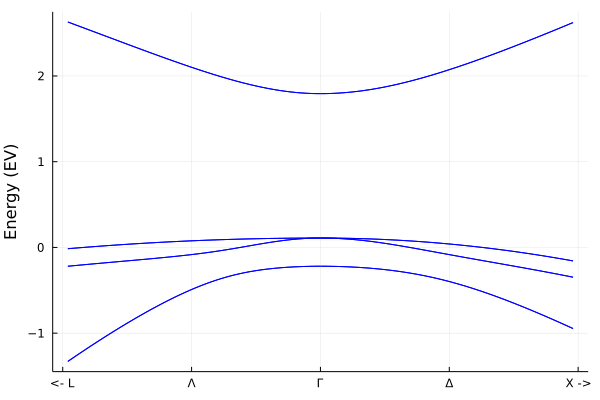

In [4]:
KPpack.PlotBands(Ex,El,Kx,Kl)

# Plot DOS

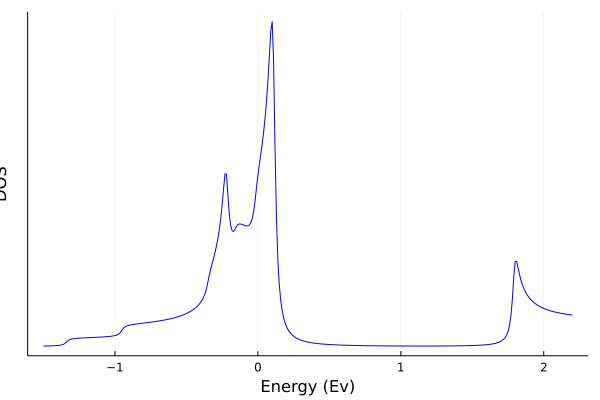

In [5]:
KPpack.PlotDOS(EDOS,aDOS)

# Make a structure

In [6]:
nlayer=3; Npts=100
layer=Array{KPpack.mat}(undef,nlayer)

layer[1]=KPpack.mat("AlGaAs_0.15",70);
layer[2]=KPpack.mat("GaAs",15);
layer[3]=KPpack.mat("AlGaAs_0.15",70);

X,boundary =KPpack.mesh(Npts,layer,nlayer);
mlayer=Array{KPpack.Materials}(undef, length(X));

boundPoints=KPpack.supParams(layer,X,boundary,mlayer,Temp);

# Plot structure

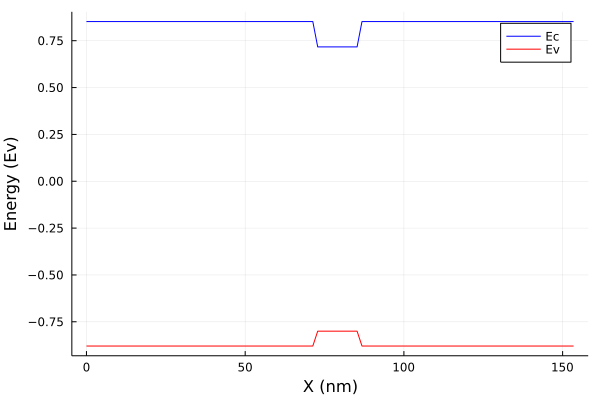

In [7]:
kind="both"
KPpack.plotProf(mlayer,X,kind)